# DATA IMPORT

In [1]:
import pandas as pd
import numpy as np

df_credit = pd.read_csv('credits.csv')
df_rating = pd.read_csv('ratings.csv')
df_movie = pd.read_csv('movies_metadata.csv')
df_keywords = pd.read_csv('keywords.csv')


/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Preprocessing

In [2]:
df_movie = df_movie[['original_title', 'id', 'title', 'adult', 'belongs_to_collection', 
                     'budget', 'genres', 'original_language', 'popularity',
                     'production_companies', 'production_countries', 'revenue', 
                     'runtime', 'spoken_languages', 'status', 'vote_average',
                     'vote_count']]

df_rating = df_rating[['movieId', 'rating']]



In [3]:
import ast

def convertType(x, typ):
    try:
        return typ(x)
    except ValueError:
        return np.NaN

df_movie['genres_parsed'] = df_movie['genres'].apply(lambda x: [d['name'] for d in ast.literal_eval(x)])
# df_movie['production_countries'] = df_movie['production_countries'].apply(lambda x: d['iso_3166_1'] for d in ast.literal_eval(x))

# convert boolean belongs_to_collection col to integer col with 1 and 0 value
df_movie['is_collection'] = df_movie['belongs_to_collection'].isnull()
df_movie['is_collection'] = df_movie['is_collection'].apply(lambda x: 1 if x==True else 0)

# convert boolean adult col to integer col with 1 and 0 value
df_movie['adult'] = df_movie['adult'].apply(lambda x: 1 if x==True else 0)
df_movie['popularity'] = df_movie['popularity'].apply(lambda x: convertType(x, float))

df_movie['budget'] = df_movie['budget'].apply(lambda x: convertType(x, int))

# DATA ADVERTISING AND BASIC ANALYSIS

/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


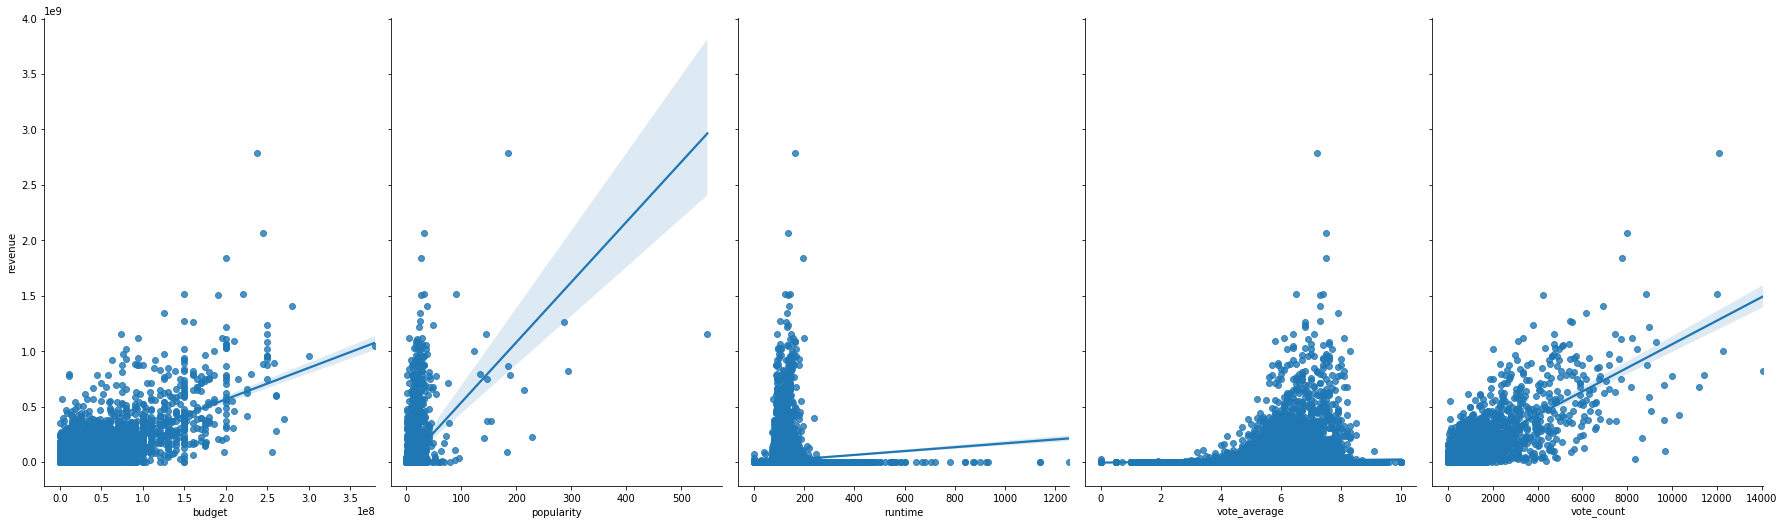

In [14]:
import seaborn as sns
x = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
# plot relationship to revenue and plotting the Least Squares Line
sns.pairplot(df_movie, x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

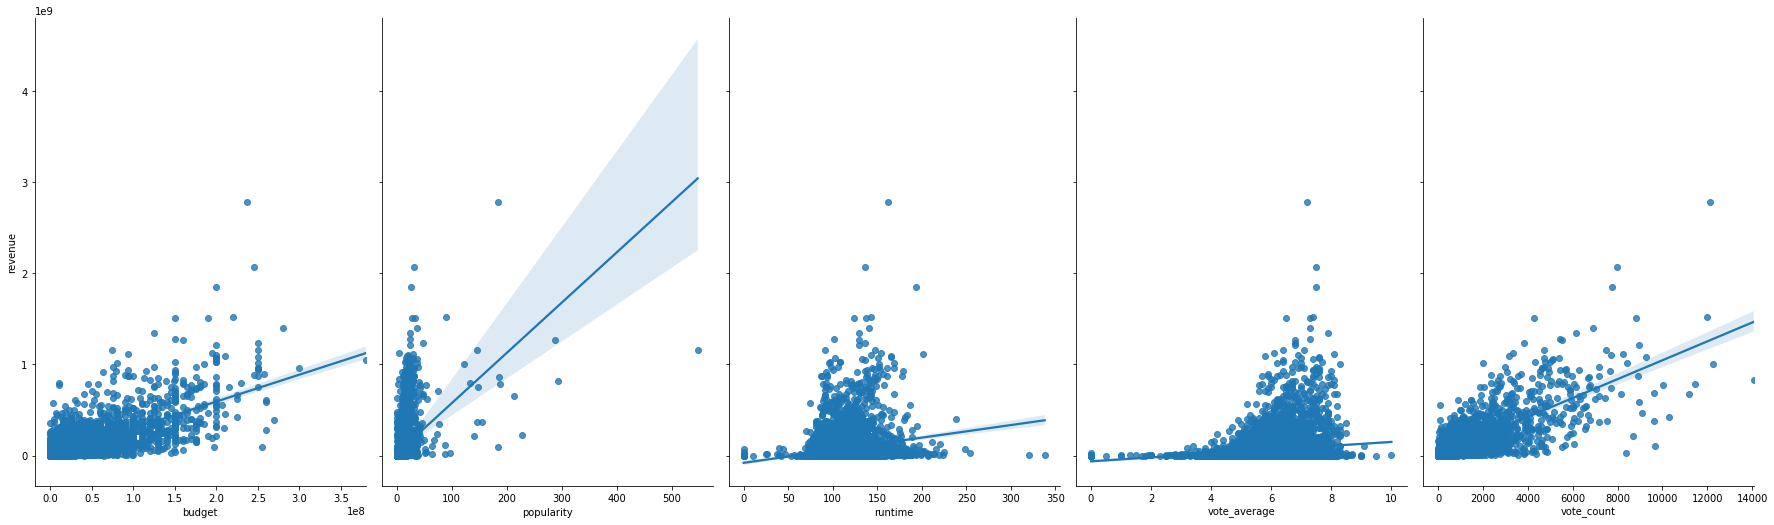

In [15]:
# filter out 0 revenue movies
import seaborn as sns
# plot relationship to revenue
sns.pairplot(df_movie[df_movie['revenue']>0], 
             x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

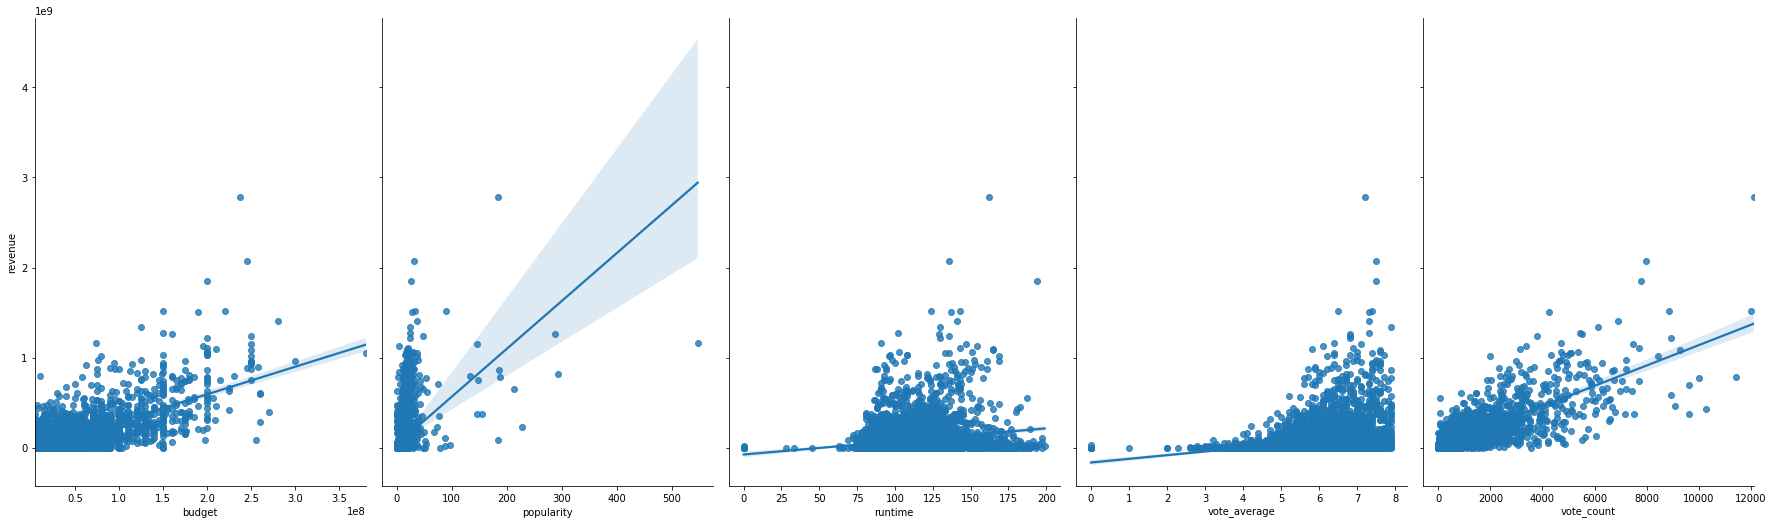

In [21]:
sns.pairplot(df_movie[np.logical_and(df_movie['vote_average'] < 8,
                                     np.logical_and(df_movie['runtime'] < 200, df_movie['budget'] > 4224578))], 
                      x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

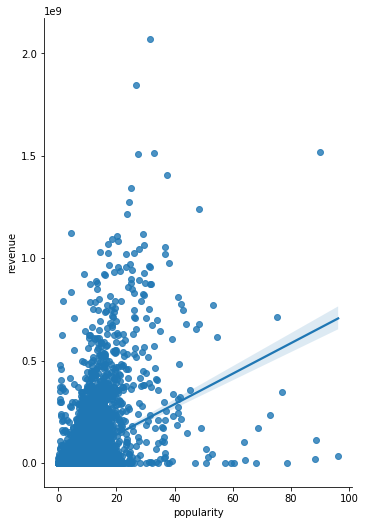

In [16]:
# popularity has extremely big r^2 value
sns.pairplot(df_movie[df_movie['popularity'] < 100], x_vars=['popularity'], y_vars='revenue', kind='reg', height=7, aspect=0.7)

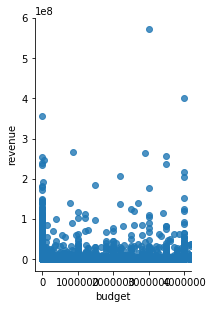

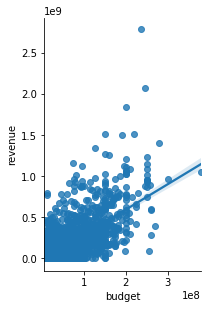

In [19]:
# too much variability in low budget films. Only going to target mainstream films for predictability.
sns.pairplot(df_movie[df_movie['budget'] <= 4224578], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['budget'] > 4224578], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)

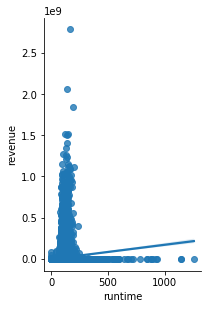

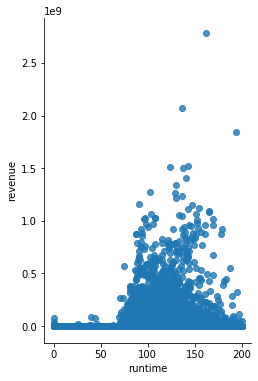

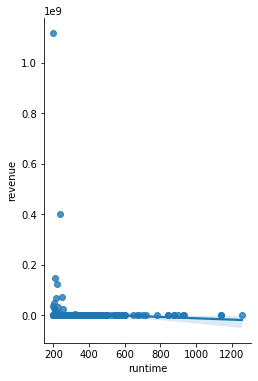

In [20]:
# too short or too long of films have really low revenue. Gaussian and therefore can't use linear regression 
# may need to cut off the films that are too long
sns.pairplot(df_movie, x_vars=['runtime'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['runtime'] <= 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)
sns.pairplot(df_movie[df_movie['runtime'] > 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)

# FEATURE EXTRACTION

In [42]:
df_movie_cleaned = df_movie

movie_cols = ['revenue', 'is_collection', 'adult', 'popularity', 
              'vote_average', 'vote_count', 'runtime', 'budget']

filter_outlier = np.logical_and(df_movie_cleaned['vote_average'] < 8,
                                               np.logical_and(df_movie_cleaned['runtime'] < 200,
                                                              df_movie_cleaned['budget'] > 4224578))

df_movie_cleaned = df_movie_cleaned[filter_outlier]
df_movie_cleaned = df_movie_cleaned[movie_cols]

# one hot encoding on categorical features
# original language
df_movie_cleaned = df_movie_cleaned.join(pd.get_dummies(df_movie[['id', 'original_language']], 
                                                        columns=['original_language'],
                                                        prefix='lang'))
#                                                         drop_first=True))

# Drop rows with any NAN
df_movie_cleaned = df_movie_cleaned.dropna()

df_movie_cleaned.astype({
    'is_collection': 'int32',
    'adult': 'int32',
    'popularity': 'float',
    'revenue': 'float',
    'vote_average': 'float',
    'vote_count': 'float',
    'runtime': 'float',
    'budget':  'int32'
})



# df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['revenue'] != 0]


,revenue,is_collection,adult,popularity,vote_average,vote_count,runtime,budget,id,lang_104.0,...,lang_tl,lang_tr,lang_uk,lang_ur,lang_uz,lang_vi,lang_wo,lang_xx,lang_zh,lang_zu
0,373554033.0,0,0,21.946943,7.7,5415.0,81.0,30000000,862,0,...,0,0,0,0,0,0,0,0,0,0
1,262797249.0,1,0,17.015539,6.9,2413.0,104.0,65000000,8844,0,...,0,0,0,0,0,0,0,0,0,0
3,81452156.0,1,0,3.859495,6.1,34.0,127.0,16000000,31357,0,...,0,0,0,0,0,0,0,0,0,0
5,187436818.0,1,0,17.924927,7.7,1886.0,170.0,60000000,949,0,...,0,0,0,0,0,0,0,0,0,0
6,0.0,1,0,6.677277,6.2,141.0,127.0,58000000,11860,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,19000000.0,1,0,1.323587,6.9,25.0,185.0,12000000,24049,0,...,0,0,0,0,0,0,0,0,0,0
45268,0.0,1,0,5.613875,5.3,153.0,100.0,5402000,277839,0,...,0,0,0,0,0,0,0,0,0,0
45343,0.0,0,0,7.294920,4.0,167.0,110.0,25868826,248705,0,...,0,0,0,0,0,0,0,0,0,0
45352,0.0,1,0,1.185515,6.1,18.0,100.0,7500000,39164,0,...,0,0,0,0,0,0,0,0,0,0


# LINEAR REGRESSION MODEL

In [44]:
x = df_movie_cleaned.iloc[:, 1:].values
y = df_movie_cleaned.iloc[:, 0].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Make Prediction
df_result = pd.DataFrame()
y_predicted = regressor.predict(x_test)
combined = np.concatenate((np.vstack((y_test)), x_test), axis=1)
df_result = pd.DataFrame(data=combined, columns=df_movie_cleaned.columns)
y_predicted = y_predicted.clip(min=0) # revenue can't be less than 0
df_result['predicted_revenue'] = y_predicted.clip(min=0)

# df_result['difference'] = np.absolute(df_result['predicted_revenue']-df_result['revenue'])/df_result['revenue']


In [45]:
import math
print('interecept: {}'.format(regressor.intercept_))
d_coefficient = {col:regressor.coef_[i] for i,col in enumerate(df_movie_cleaned.iloc[:, 1:].columns)}
sorted(d_coefficient.items(), key=lambda x: abs(x[1]), reverse=True)

interecept: 7660570.901523545


[('lang_te', 49795339.62756492),
 ('is_collection', -45305024.983354315),
 ('lang_th', -40751379.19613737),
 ('lang_ta', 30765899.628195137),
 ('lang_sv', -29058002.527632803),
 ('lang_cn', -23897643.255040213),
 ('lang_xx', 23716669.29955209),
 ('lang_he', 23184817.280080084),
 ('lang_fr', -19394687.271190725),
 ('lang_ml', 16625993.073403768),
 ('lang_en', -13977647.823660217),
 ('lang_hi', 13636293.822845588),
 ('lang_ja', -13152574.645721033),
 ('lang_nl', -11700617.358955583),
 ('lang_ca', -11110823.25890599),
 ('lang_it', -11070879.60228412),
 ('lang_pt', 10584962.83418643),
 ('lang_fi', 8446861.788198764),
 ('lang_da', -8391020.139666772),
 ('lang_ko', 7747064.545427623),
 ('lang_de', -7228687.904417742),
 ('lang_sr', -6297330.96460064),
 ('lang_zh', 5585141.968199088),
 ('lang_cs', 4626986.612646936),
 ('lang_pl', 2573282.4550887602),
 ('vote_average', 1817002.8315401617),
 ('lang_no', 1744925.637303107),
 ('lang_es', -1625492.7762036521),
 ('lang_tr', -1399940.3409380747),
 ('

In [46]:
import sklearn.metrics as metrics
# print(y_test)
# print(y_predicted)
metrics.r2_score(y_test, y_predicted.clip(min=0))

0.7553056653509724

In [ ]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder# instantiate OneHotEncoder
df_movie['original_language']
ohe = OneHotEncoder().fit(df_movie['original_language']) 
# categorical_features = boolean mask for categorical columns
# sparse = False output an array not sparse matrix

In [ ]:
import re

df_credit
import ast
keywords = ast.literal_eval(df_keywords.iloc[0]['keywords'])
keywords
# re.split("},", df_credit.iloc[0]['cast'].strip(']['))
# df_credit.iloc[0]['cast'].strip('][')
# pd.to_numeric(df_movie['popularity'])
# df_movie.iloc[35587]

In [ ]:
categorical_feature_mask = df_movie.dtypes==object
categorical_feature_mask

In [ ]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder# instantiate OneHotEncoder
df_movie['genre_cleaned'] = df_movie['genres'].apply(lambda x: [d['name'] for d in ast.literal_eval(x)])

df_movie['is_collection'] = df_movie['belongs_to_collection'].isnull()
df_movie['is_collection'] = df_movie['is_collection'].apply(lambda x: 1 if x==True else 0)
df_movie['is_collection']

df_movie['adult'] = df_movie['adult'].apply(lambda x: 1 if x==True else 0)

df_movie['popularity'] = 
df_movie.astype({
    'is_collection': 'int32',
    'adult': 'int32',
    'popularity': 'float'
})

# df_movie['is_collection']
# df_movie['genre_cleaned'] 
# ohe = OneHotEncoder().fit(df_movie['genre_cleaned']) 
# categorical_features = boolean mask for categorical columns
# sparse = False output an array not sparse matrix

In [ ]:
df_movie['budget'].mean()

In [ ]:
df_result